In [16]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../")
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from scipy.spatial import distance
from scripts import modeimputer

In [48]:
data = pd.read_csv("../datasets/YPDS_merge.csv")
data.head(10)

,00class,37cgrowth,40cgrowth,50%glucosegrowth,60%glucosegrowth,acidproduction,acidtolerant,amdglucoside,arbutinhydrolysis,cadaverine,...,sorbitol,sorbose,starchproduction,succinicacid,sucrose,trehalose,ureaseactivity,vitaminfreegrowth,xylitol,xylose
0,9,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,NaN,1.0,1.0
1,9,0.0,NaN,1.0,NaN,-1.0,NaN,-1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2,9,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,NaN,1.0,-1.0,1.0,NaN,-1.0,-1.0,NaN,1.0,1.0
3,9,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,NaN,1.0,1.0
4,9,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,NaN,1.0,1.0
5,5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,...,-1.0,1.0,-1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0
6,5,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,NaN,1.0,1.0
7,5,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,NaN,1.0,1.0
8,5,1.0,NaN,-1.0,NaN,-1.0,NaN,-1.0,-1.0,1.0,...,1.0,0.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
9,5,NaN,NaN,NaN,NaN,-1.0,NaN,1.0,-1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0


In [49]:
def missingProportion(data, column):
    return data[column].isnull().sum()/data.shape[0]

# Préprocessamento
Remover todas as colunas com mais de 20% ~ 50% e todas as linhas com mais de 5% de dados faltantes e fazer a imputação pela moda da classe

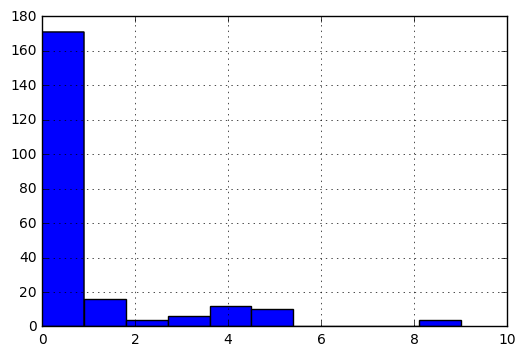

In [66]:
#removendo linhas com mais de x% de dados faltantes
rows = data.shape[0]
columns = data.shape[1]
dels = []
for i in range(rows):
    if sum(data.iloc[i].isnull())/columns > 0.05:
        dels.append(i)
        
data.drop(data.index[dels], inplace=True)
print(data.shape)

In [68]:
preprocessedDatasets = {}
missingValues = [0.20, 0.30, 0.40, 0.50]

In [69]:
for v in missingValues:
    temp = pd.DataFrame().append(data)
    for c in data.columns:
        if missingProportion(temp, c) > v:
            temp.drop(c, axis=1, inplace=True)
    preprocessedDatasets[v] = temp

In [70]:
for key, value in preprocessedDatasets.items():
    print("%.2f | %d" % (key, value.shape[1]))
    preprocessedDatasets[key] = modeimputer.imputeByClassMode(preprocessedDatasets[key])

0.20 | 53
0.30 | 53
0.40 | 53
0.50 | 53


# Auxiliares
Métodos auxiliares para fazer a validação cruzada

In [79]:
#Essa função extrai de um dataframe os valores de indices presentes em um vetor
def extractIndexes(dataframe, indexes):
    extracted = dataframe[dataframe.index == indexes[0]]
    for i in indexes[1:]:
        extracted = extracted.append(dataframe[dataframe.index==i])
    return extracted

#Calcula a acurácia  média fazendo um 5*3 kfold
def meanAccuracy(data, labels, classifier, params):
    kfolds = StratifiedKFold(n_splits=5)
    return _KFoldMeanAccuracy(data, labels, kfolds, classifier, params)

def _KFoldMeanAccuracy(data, labels, kfolds, classifier, params):
    accuSum = 0
    folds = kfolds.split(data, labels['00class'])
    for train, test in folds:
        _trainData= extractIndexes(data, train)
        _trainClasses = extractIndexes(labels, train)
        #Usando os KFolds computados, faz um 3-fold interno para calcular a acurácia media esperada
        clf = GridSearchCV(classifier, params, scoring='f1_micro')
        clf.fit(_trainData, _trainClasses['00class'])
        accuSum += clf.best_score_
    return accuSum/5
    
#Escolhe os melhores hiperparametros fazendo um 3-fold
def bestHParams(data, labels, classifier, params):
    clf = GridSearchCV(classifier, params, scoring='f1_micro')
    clf.fit(data, labels['00class'])
    return (clf.best_score_, clf.best_params_)

## Validação Cruzada e Seleção do Modelo
Aqui, faremos uma validação cruzada em 5x3-Fold, para Random Forests, KNN, e Gradient Boosting Machines
com os hiperparametros abaixo.

In [80]:
#Define os classificadores a serem testados e seus parâmetros
estimators = {
    'RF' : {'estimator' : RandomForestClassifier(), 
            'params' :  {'max_features':[10,15,20,25], 'n_estimators':[100,200,300,400]}},
    'KNN': {'estimator' : KNeighborsClassifier(),
            'params' : {'n_neighbors': [1,5,11,15,21], 'algorithm': ['ball_tree']}},
    'GBM': {'estimator' : GradientBoostingClassifier(),
            'params' : {'n_estimators':[30,70,100], 'learning_rate':[0.1, 0.05], 'max_depth':[5]}}
}

Treinando cada um dos modelos para cada diferente valor de corte das colunas com dados faltantes

In [81]:
for v, dataset in preprocessedDatasets.items():
    _labels = dataset[['00class']]
    _data = dataset.drop('00class', axis = 1)
    print("%.2f" % v)
    for estimator, eData in estimators.items():
        results = meanAccuracy(_data,_labels, eData['estimator'], eData['params'])
        _, params = bestHParams(_data,_labels, eData['estimator'], eData['params'])
        print("%s : %.4f, %s" % (estimator, results, params))

0.20
KNN : 0.9953, {'n_neighbors': 1, 'algorithm': 'ball_tree'}
RF : 0.9953, {'max_features': 10, 'n_estimators': 400}
GBM : 0.9809, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
0.30
KNN : 0.9953, {'n_neighbors': 1, 'algorithm': 'ball_tree'}
RF : 0.9953, {'max_features': 10, 'n_estimators': 100}
GBM : 0.9809, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
0.40
KNN : 0.9953, {'n_neighbors': 1, 'algorithm': 'ball_tree'}
RF : 0.9953, {'max_features': 15, 'n_estimators': 200}
GBM : 0.9809, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
0.50
KNN : 0.9953, {'n_neighbors': 1, 'algorithm': 'ball_tree'}
RF : 0.9953, {'max_features': 10, 'n_estimators': 100}
GBM : 0.9809, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
